## Summer (Jun-Aug) Mesozooplankton Productivity Anomalies

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(0, 900), 'x': slice(0, 400)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2010, 2020), ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(6, 9):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_dia2_T.nc') as ds:
            for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Add total grazing fields
aggregates['MZ_Prod'] = {}
variables.append('MZ_Prod')
for year in years:
    aggregates['MZ_Prod'][year] = sum(aggregates[var][year] for var in ['GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ'])

# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['MZ_Prod','GRMESZDIAT', 'GRMESZMRUB', 'GRMESZPHY', 'GRMESZPON', 'GRMESZMICZ']

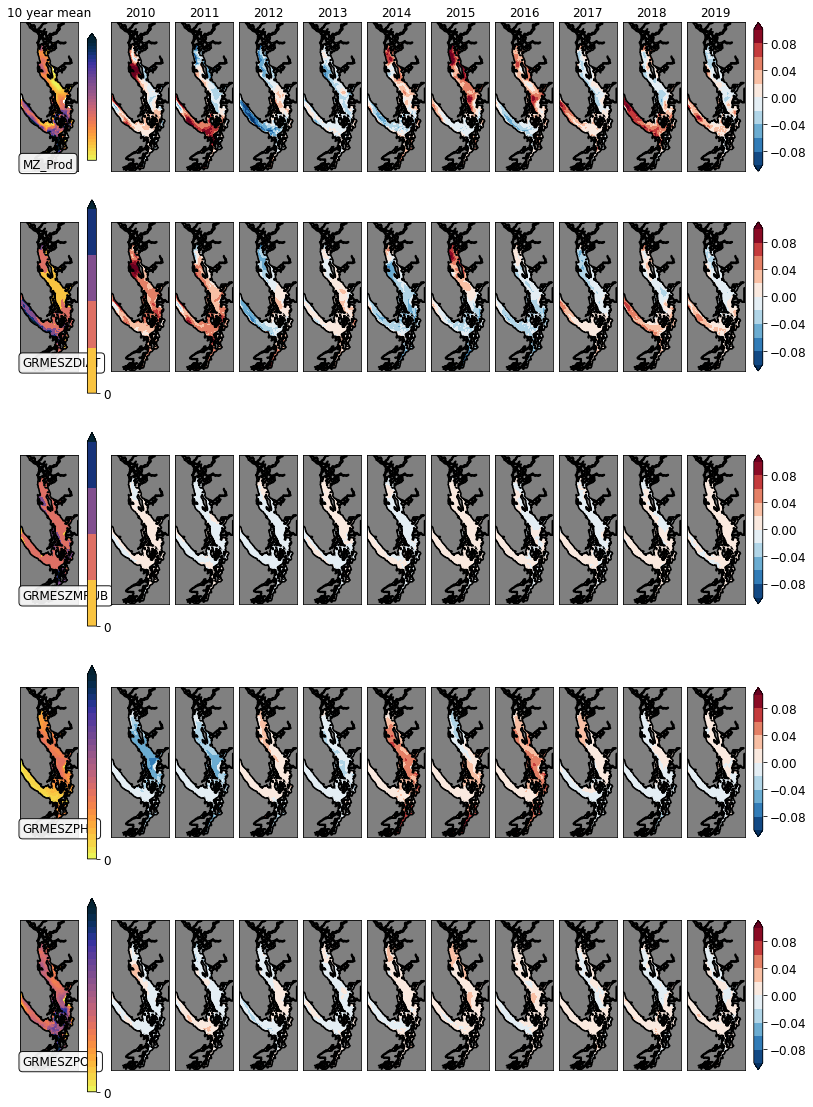

In [5]:
gridspec_kw = {'height_ratios': [0.7, 1, 1, 1, 1], 'wspace': 0.1, 'hspace': 0.05}
fig, axs = plt.subplots(5,11, figsize=(12.5, 20), gridspec_kw=gridspec_kw)

cmaps = ['cmo.thermal_r', 'cmo.thermal_r', 'cmo.thermal_r', 'cmo.thermal_r', 'cmo.thermal_r']
clims = [(0.3,0.7, 0.01), (0,0.5, 0.1), (0,0.05, 0.01), (0,0.3, 0.01), (0,0.3, 0.01)]
dclims = [(-0.1,0.11,0.02), (-0.1,0.11,0.02), (-0.1,0.11,0.02), (-0.1,0.11,0.02), (-0.1,0.11,0.02)]
for row, var, cmap, clim, dclim, dcbar in zip(axs, variables, cmaps, clims, dclims, [1, 5, 5, 5, 5]):
    
    c = row[0].contourf(((aggregates[var]['mean'])*86400*0.3*5.7*12/1000), levels=np.arange(*clim), cmap=cmap, extend='max')
    pos = row[0].get_position()
    row[0].set_position([pos.x0-0.03, pos.y0, pos.width, pos.height])
    cax = fig.add_axes([pos.x1-0.02, pos.y0+0.01, 0.01, pos.height-0.02])
    fig.colorbar(c, cax=cax, ticks=range(0, 101, dcbar))
    row[0].text(0.04, 0.03, var, transform=row[0].transAxes, bbox={'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9})
    if var == 'MZ_Prod': row[0].set_title('10 year mean', fontsize=12)
    
    for ax, year in zip(row[1:], years):
    
        c = ax.contourf(((aggregates[var][year])*86400*0.3*5.7*12/1000), levels=np.arange(*dclim), cmap='RdBu_r', extend='both')
        if var == 'MZ_Prod': ax.set_title(year, fontsize=12)
    
    for ax in row:
        landmask = tmask
        ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
        ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)
    
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+0.01, pos.y0, 0.01, pos.height])
    fig.colorbar(c, cax=cax)

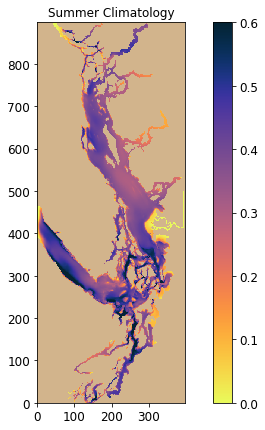

In [19]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')
vmin=0
vmax=.6
cmap1=cmocean.cm.thermal_r
cmap1.set_bad('tan')
il=0

fig,ax=plt.subplots(1,1,figsize=(10,7))
#fig.suptitle('Annual Anomalies Mesozoop Feeding on Diatoms', fontsize=16)
m0=ax.pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod']['mean'])*86400*0.3*5.7*12/1000)),cmap=cmap1,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax,coords='grid')
ax.set_title('Summer Climatology')
fig.colorbar(m0,ax=ax)

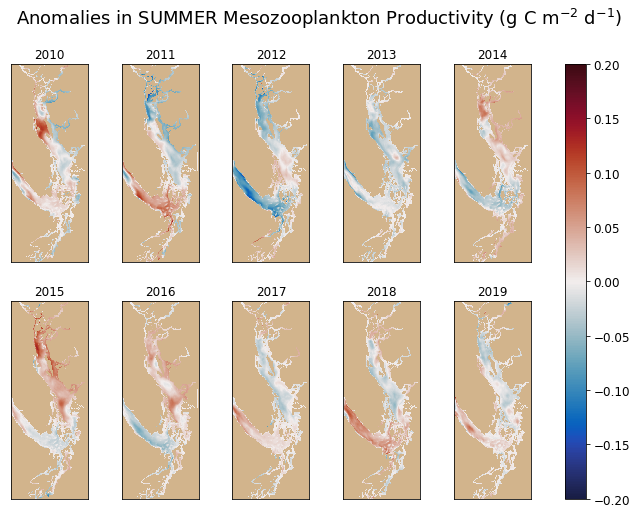

In [21]:
##### with pcolormesh: no smoothing
cmap0=cmocean.cm.balance
cmap0.set_bad('tan')

#cmap1=cmocean.cm.haline
#cmap1.set_bad('k')
il=0
vmin=-0.2
vmax=0.2

fig,ax=plt.subplots(2,5,figsize=(12,8))
fig.suptitle('Anomalies in SUMMER Mesozooplankton Productivity (g C m$^{-2}$ d$^{-1}$)', fontsize=18)


m0=ax[0,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2010])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,0],coords='grid')
ax[0,0].set_title('2010')
ax[0,0].yaxis.set_visible(False)
ax[0,0].xaxis.set_visible(False)
ax[0,0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[0,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2011])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,1],coords='grid')
ax[0,1].set_title('2011')
ax[0,1].yaxis.set_visible(False)
ax[0,1].xaxis.set_visible(False)
ax[0,1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[0,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2012])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,2],coords='grid')
ax[0,2].set_title('2012')
ax[0,2].yaxis.set_visible(False)
ax[0,2].xaxis.set_visible(False)
ax[0,2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[0,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2013])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,3],coords='grid')
ax[0,3].set_title('2013')
ax[0,3].yaxis.set_visible(False)
ax[0,3].xaxis.set_visible(False)
ax[0,3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[0,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2014])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[0,4],coords='grid')
ax[0,4].set_title('2014')
ax[0,4].yaxis.set_visible(False)
ax[0,4].xaxis.set_visible(False)
ax[0,4].yaxis.set_visible(False)


##row 2
m0=ax[1,0].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2015])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,0],coords='grid')
ax[1,0].set_title('2015')
ax[1,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)
ax[1,0].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[1])

m0=ax[1,1].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2016])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,1],coords='grid')
ax[1,1].set_title('2016')
ax[1,1].yaxis.set_visible(False)
ax[1,1].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[2])

m0=ax[1,2].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2017])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,2],coords='grid')
ax[1,2].set_title('2017')
ax[1,2].yaxis.set_visible(False)
ax[1,2].xaxis.set_visible(False)
ax[1,2].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[3])

m0=ax[1,3].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2018])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,3],coords='grid')
ax[1,3].set_title('2018')
ax[1,3].yaxis.set_visible(False)
ax[1,3].xaxis.set_visible(False)
ax[1,3].yaxis.set_visible(False)
#fig.colorbar(m0,ax=ax[4])

m0=ax[1,4].pcolormesh(np.ma.masked_where(tmask==0,((aggregates['MZ_Prod'][2019])*86400*0.3*5.7*12/1000)),cmap=cmap0,vmin=vmin,vmax=vmax)
viz_tools.set_aspect(ax[1,4],coords='grid')
ax[1,4].set_title('2019')
ax[1,4].yaxis.set_visible(False)
ax[1,4].xaxis.set_visible(False)
ax[1,4].yaxis.set_visible(False)

fig.colorbar(m0,ax=ax)